In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# params
lr = 3e-4
z_dim = 64
image_dim = 28 * 28
batch_size = 32
num_epochs = 10


In [3]:
# mnist stuff
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="./data", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 35.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.81MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.41MB/s]


In [4]:
# generatr

class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


In [5]:
# discriminator

class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [6]:
gen = Generator(z_dim, image_dim).to(device)
disc = Discriminator(image_dim).to(device)

opt_gen = optim.Adam(gen.parameters(), lr=lr)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, z_dim).to(device)


In [7]:
# train

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 28*28).to(device)
        batch_size = real.size(0)

        # discriminator
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)

        disc_real = disc(real).view(-1)
        disc_fake = disc(fake.detach()).view(-1)
        loss_disc = (criterion(disc_real, torch.ones_like(disc_real)) +
                     criterion(disc_fake, torch.zeros_like(disc_fake))) / 2

        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # generator
        output = disc(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")


Epoch [1/10]  Loss D: 0.5980, Loss G: 4.0729
Epoch [2/10]  Loss D: 0.0574, Loss G: 4.0257
Epoch [3/10]  Loss D: 0.2738, Loss G: 6.5379
Epoch [4/10]  Loss D: 0.3350, Loss G: 5.6655
Epoch [5/10]  Loss D: 0.0945, Loss G: 3.8500
Epoch [6/10]  Loss D: 0.1772, Loss G: 3.3456
Epoch [7/10]  Loss D: 0.2104, Loss G: 3.6460
Epoch [8/10]  Loss D: 0.3021, Loss G: 2.3045
Epoch [9/10]  Loss D: 0.2754, Loss G: 2.6914
Epoch [10/10]  Loss D: 0.3323, Loss G: 3.0799


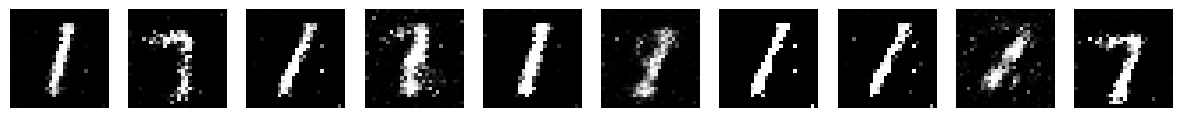

In [8]:
# sample images
gen.eval()
with torch.no_grad():
    fake_images = gen(fixed_noise).reshape(-1, 1, 28, 28).cpu()

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(fake_images[i].squeeze(), cmap="gray")
    axes[i].axis("off")
plt.show()
